In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import time 
import matplotlib.pyplot as plt
import os
import shutil
import logging

logging.disable(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

%matplotlib inline

### Configuring the GPU usage

In [3]:
physical_gpus = tf.config.list_physical_devices('GPU')

for gpu in physical_gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(f'Enabled memory growth for {gpu}')

gpu = physical_gpus[1]   

tf.config.set_visible_devices([gpu], 'GPU')

print("Logical GPU's: ", tf.config.list_logical_devices('GPU'))
    
#strategy = tf.distribute.MirroredStrategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE


Enabled memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Enabled memory growth for PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
Logical GPU's:  [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


### Setting up some path variables

In [13]:
model_name = 'translator_de_en'
version = 1
package_path = os.path.join(model_name, f'{version:04d}')
model_file = os.path.join(package_path, 'model.py')
init_file = os.path.join(package_path, '__init__.py')
preprocessing_file = os.path.join(package_path, 'preprocessing.py')
vocabulary_path = os.path.join(package_path, 'vocabularies')  # change this to the location of your vocabulary files 
checkpoint_path = os.path.join(package_path, 'checkpoints')

if not os.path.exists(package_path):
    os.makedirs(package_path)
    

### Loading the tokenizers if they already exist

In [14]:
inp_vocabulary_file = os.path.join(vocabulary_path, 'input_vocabulary')
outp_vocabulary_file = os.path.join(vocabulary_path, 'output_vocabulary')

# creating a dictionary of tokenizers
try:
    tokenizer = {}
    tokenizer['input'] = tfds.features.text.SubwordTextEncoder.load_from_file(inp_vocabulary_file)
    tokenizer['output'] = tfds.features.text.SubwordTextEncoder.load_from_file(outp_vocabulary_file)
except:
    print("No tokenizers found! Use 'build_and_save_tokenizer' to create some")

## Writing helper function and classes

In [5]:
#%%writefile  utils.py

class BeamSearch(tf.Module):
    
    def __init__(self, model, tokenizer, beam_width, max_seq_length, **kwargs):
        super(BeamSearch, self).__init__(**kwargs)
        self.model = model
        self.inp_tokenizer = tokenizer['input']
        self.outp_tokenizer = tokenizer['output']
        self.inp_vocab_size = self.inp_tokenizer.vocab_size
        self.outp_vocab_size = self.outp_tokenizer.vocab_size
        self.beam_width = beam_width
        self.max_seq_length = max_seq_length
        self.stop_words = ['.', ' .', ' . ', '!', ' !', ' ! ', '?', ' ?', ' ? ']
        self.stop_codes = [0] + list(map(lambda x: self.outp_tokenizer.encode(x)[0], self.stop_words))
    
    
        
    def __call__(self, sentence):
    
        # the probability distribution choosing <end> with certainty
        end_distribution = tf.constant([1.] + self.outp_vocab_size*[0.], shape=[1, self.outp_vocab_size + 1])
    
        # add a <start> and <end> token to the input sentence and encode the result
        enc_inp_sentence = tf.constant([self.inp_vocab_size] + self.inp_tokenizer.encode(sentence) + [0])    
        enc_inp_sentence = enc_inp_sentence[tf.newaxis, : ]  # add a batch dimension
    
        # the encoded sentences
        # the start sentence is just <start>
        decoder_input = tf.constant(self.outp_vocab_size, shape=[1,1], dtype=tf.int32) 
    
        # the probability of our sentences
        # the start sentence has probability one
        proba = tf.ones(shape=[1, 1], dtype=tf.float32)  
    
        for i in range(1, self.max_seq_length):
        
            # is the previous sentence ending with <end>
            condition = tf.map_fn(lambda x: x in self.stop_codes, decoder_input[:, -1], dtype=tf.bool)[ : , tf.newaxis] 
        
            # if all sentences end with <end>, stop the iteration
            if tf.reduce_all(condition == True):
                break
        
            # repeat the input sentence as many times as given by the batch size of decoder_input
            encoder_input = tf.repeat(enc_inp_sentence, repeats = decoder_input.shape[0], axis=0)
            
            # computing the predictions using the model
            predictions = self.model({'encoder_input': encoder_input, 'decoder_input': decoder_input}, training=False)

            # compute the conditional probabilities for the next word 
            # do this for each previous sentence 
            probabilities = tf.nn.softmax(predictions[:, -1, :], axis = -1)  # (beam_width, output_vocab_size)
                
            # if previous sentence ends with <end>, pic end_distribution to choose <end> again
            probabilities = tf.where(condition, end_distribution, probabilities)
        
            # choose the highes conditional probabilities for each previous sentence
            top_cond_proba, top_words = tf.math.top_k(probabilities, k = self.beam_width)  # (beam_width, beam_width)
        
            # compute the probabilities for the new sentences and flatten the results
            top_proba = tf.reshape(proba[:,tf.newaxis] * top_cond_proba, shape = [-1]) 
        
            # flatten the lists of best next words
            top_words = tf.reshape(top_words, shape = [-1])
            
            # choose among all sentence probabilities the best beam_width
            proba, top_idx = tf.math.top_k(top_proba, k = self.beam_width)
    
            # pic the associated best next words
            top_words = tf.gather(params = top_words, indices = top_idx) 

            # pic the previous sentences giving rise to the best next words
            top_dec_inputs = tf.gather(params = decoder_input, indices = top_idx // self.beam_width)
        
            # extend the previous sentences with their best next words
            decoder_input = tf.concat([ top_dec_inputs, top_words[:, tf.newaxis] ], axis = -1)
            
        translations= tf.map_fn(lambda x: self.outp_tokenizer.decode(x), decoder_input[:,1:], dtype=tf.string)
        
        return [translations, proba] 
        #return decoder_input
    
    
    
    def translations(self, sentence):
        # compute self.beam_width many translations
        translations, probabilities = self.__call__(sentence)
        
        print(f'Input: {sentence}\n')
        for i, translation in enumerate(translations):
            print(f'Translation {i+1} with probability {100*probabilities[i]:.3f}%')
            print(translation.numpy().decode() + '\n')
        
    
    
    def translate(self, sentence):
        # compute self.beam_width many translations
        translations, probabilities = self.__call__(sentence)
        
        # pick the best and return it
        best_idx = tf.argmax(probabilities).numpy()
        return [translations[best_idx], probabilities[best_idx]]
    

In [7]:
#%%writefile  $init_file


In [9]:
#%%writefile  $preprocessing_file

import tensorflow as tf
import tensorflow_datasets as tfds
import os

AUTOTUNE = tf.data.experimental.AUTOTUNE



def build_and_save_tokenizer(corpus, max_vocab_size, directory = None):
    """Takes a corpus dataset consisting of pairs. Each pair is a sentence in the input language and its 
       translation into the output language. A pair of SubwordTextEncoders is build using the corpus and 
       saved to disc.
    
    Args:
        corpus, a dataset of text: shape == (2,), dtype == tf.string
        max_vocab_size: shape == (), dtype == tf.int64    # the maximal vocabulary size of the SubwordTextEncoders
        directory: shape == (), dtype == tf.string    # the directory holding the two saved Encoders
    """
      
        
    inp_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
                        (inp.numpy() for inp, outp in corpus), target_vocab_size = max_vocab_size)

    outp_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
                        (outp.numpy() for inp, outp in corpus), target_vocab_size = max_vocab_size)
    
    if directory == None:
        directory = os.getcwd()
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    inp_tokenizer.save_to_file(os.path.join(directory, 'input_vocabulary'))
    outp_tokenizer.save_to_file(os.path.join(directory, 'output_vocabulary'))





def input_fn(corpus, tokenizer, max_length = 40, batch_size = 64, shuffle_buffer_size = 1, 
             training=False, transformer=True):
    """Takes a corpus dataset consisting of pairs. Each pair is a sentence in the input language and its 
       translation into the output language. Both sentences will be tokenizes and encoded 
       resulting in a pair of sequences of integers. The dataset of such pairs will be batched,
       padded and prefetched.
       
    Args:
        corpus, a dataset of text: shape == (2,), dtype == tf.string
        tokenizer, a dictionary of SubwordTextEncoders, keys = ['input', 'output']
        max_length: shape == (), dtype == tf.int64
        batch_size: shape == (), dtype == tf.int64
        shuffle_buffer_size: shape == (), dtype == tf.int64
        training: shape == (), dtype == tf.bool   
        
        
    Returns:
        dataset of batches: shape == (2, batch_size, None), dtype == tf.int64
    """
    
    inp_tokenizer = tokenizer['input']
    outp_tokenizer = tokenizer['output']

        
        
    def encode(inp_sentence, outp_sentence):
        """Tokenizing and encoding our input and output sentences"""
        
        inp_sequence = inp_tokenizer.encode(inp_sentence.numpy())
        outp_sequence = outp_tokenizer.encode(outp_sentence.numpy())
        
        # add a code for a start (code = vocab_size) and end (code = 0) token
        inp_sequence = [inp_tokenizer.vocab_size] + inp_sequence + [0]
        outp_sequence = [outp_tokenizer.vocab_size] + outp_sequence + [0]
        
        return inp_sequence, outp_sequence
        
    
     
    def tf_encode(inp_sentence, outp_sentence):
        """Wrapping the non-Tensorflow 'encode' function into a 'tf.py_function' 
           turing it into a Tensorflow function which can be used in graph mode.
           Such a Tensorflow function is need by the map() method below.""" 
        
        inp_sequence, outp_sequence =  tf.py_function(func = encode, 
                                                       inp = [inp_sentence, outp_sentence], 
                                                      Tout = [tf.int32, tf.int32])
        
        inp_sequence.set_shape([None])   # The length depends on the sentence
        outp_sequence.set_shape([None])  # We provide a 'shape' argument to avoid errors  
    
        return inp_sequence, outp_sequence


    
    def filter_max_length(inp_sequence, outp_sequence):
        """Creating a boolean mask marking all pairs of sequences of length <= max_length"""
        
        mask = tf.logical_and(tf.size(inp_sequence) <= max_length,
                              tf.size(outp_sequence) <= max_length)
        
        return mask
    
    
    
    # apply the encode and filter functions; cache, shuffle and pad the dataset
    sequences = corpus.map(tf_encode, num_parallel_calls=AUTOTUNE).filter(filter_max_length).cache()
    
    # if in training mode, shuffle the data and repeat infinitely many times
    if training:
        sequences = sequences.shuffle(shuffle_buffer_size, seed=1).repeat(None)
    
    # batch the sequences and apply padding, sequence length will be the longest in a batch
    batches = sequences.padded_batch(batch_size)
                
    # if the dataset feeds the transformer, rearrange input and output
    if transformer:
        batches = batches.map(lambda x, y: ({ 'encoder_input': x, 'decoder_input': y[:,:-1] }, y[:,1:]), 
                              num_parallel_calls=AUTOTUNE)

        
    return batches.prefetch(AUTOTUNE)

In [9]:
class Scale(tf.keras.layers.Layer):
    
    def __init__(self, factor, **kwargs):
        super(Scale, self).__init__(**kwargs)
        self.factor = factor
      
    
    
    def call(self, inputs):
        return inputs*self.factor
    
    
    
    def compute_mask(self, inputs, mask=None):
        return inputs._keras_mask
    
    
    
    def get_config(self):
        base_config = super(Scale, self).get_config()
        return {**base_config, 'factor': self.factor}
    

In [10]:
class MHA(tf.keras.layers.Layer):    # Multi Head Attention
    
    def __init__(self, d_query, d_value, n_heads, direction=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # adding some attributes
        self.d_query = d_query      # dimension of the query space
        self.d_value = d_value      # dimension of the value space
        self.n_heads = n_heads      # number of heads
        self.direction = direction  # time direction to which paying attention to
                                    # if not 'past' or 'future' is selected, it will be 'both'
                                    # default is 'None' resulting in 'both'
        
        # adding some dense layers
        self.dense_q = tf.keras.layers.Dense(d_query)  # for query
        self.dense_k = tf.keras.layers.Dense(d_query)  # for key 
        self.dense_v = tf.keras.layers.Dense(d_value)  # for value
        self.dense_a = tf.keras.layers.Dense(d_value)  # for attention
        
        
        self.c_query = self.d_query // self.n_heads   # num of query channels per head
        self.c_value = self.d_value // self.n_heads   # num of value channels per head
        
        
        
    def create_direction_mask(self, shape, dtype):
        """Create a boolean mask depending on the self.direction argument. This mask controls 
           whether or not information can flow forwards, backwards or in both time directions.
           
        Args:
            shape: shape == (2,), dtype == tf.int64   # shape of the boolean mask
            dtype: object of class tf.dtypesint64E  # the data type to which the mask shall be casted
            
        Returns:
            mask: shape == (2,), dtype = dtype
        """
        
        if self.direction == 'past':
            return tf.linalg.band_part(tf.ones(shape, dtype), -1, 0)
        elif self.direction == 'future':
            return tf.linalg.band_part(tf.ones(shape, dtype), 0, -1)
        else:
            return tf.ones(shape, dtype)
    
    
    
    def split_heads(self, x, channels):
        """Split the last dimension into (n_heads, channels).
           Transpose the result such that the shape is (batch_size, n_heads, n_query/key , channels).
           The last step allows broadcasting over n_heads."""
        
        x = tf.reshape(x, shape=(tf.shape(x)[0], -1, self.n_heads, channels))
        
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    
    
    def scaled_dot_product_attention(self, Query, Key, Value, Mask=None):
        """Calculate the dot product attention
    
        Args:
            Query: shape == (batch_size, n_heads, n_query, d_query)
            Key: shape == (batch_size, n_heads, n_key, d_query)
            Value: shape == (batch_size, n_heads, n_key, d_value)
            Mask: shape == (batch_size, n_heads, n_query, n_key) 
    
        Returns:
            attention_matrix: shape == (batch_size, n_heads, n_query, d_value)
            weight_matrix: shape == (batch_size, n_heads, n_query, n_key)
        """
        
        d_query = tf.cast(tf.shape(Query)[-1], dtype=Query.dtype)  # dimension of query as float

        score_matrix = tf.matmul(Query, Key, transpose_b=True) / tf.math.sqrt(d_query)   
        # (batch_size, n_heads, n_query, n_key)

        if Mask is not None:
            score_matrix += (1.0 - Mask) * -1e19 

        weight_matrix = tf.nn.softmax(score_matrix, axis = -1)   # (batch_size, n_heads, n_query, n_key)

        attention_matrix = tf.matmul(weight_matrix, Value)     # (batch_size, n_heads, n_query, d_value)
        
        return attention_matrix, weight_matrix
    
    
    
    def call(self, query, key, value):
        
        dtype = query.dtype  # the data type of query, key and value        
        batch_size = tf.shape(query)[0] # batch size of query, key and value 
             
        
        # To use tf.matmul(), it will be convenient to flatten the inner dimensions.
        # Ex: a tensor of shape [d0, d1, d2, d3, d4] will become a tensor of shape [d0, d1 + d2 + d3, d4]
        # This step will be reversed later.
        Query = tf.reshape(query, shape = [batch_size, -1, self.d_query] )  # flatten the inner dimensions
        Key = tf.reshape(key, shape = [batch_size, -1, self.d_query])       # flatten the inner dimensions 
        Value = tf.reshape(value, shape = [batch_size, -1, self.d_value])   # flatten the inner dimensions
        
        # computing the inner shapes, i.e. shapes without first (batch_size) and last dimension (d_query)
        # these shapes have been flattened in the previous step
        # Ex: in the previous example this is [d1, d2, d3]
        inner_query_shape = tf.shape(query)[1:-1]   
        inner_key_shape = tf.shape(key)[1:-1]
        
        # computing the size of the flattened inner shape, i.e. its total dimension
        # Ex: in the previous example this is d1 + d2 + d3
        n_query = tf.shape(Query)[1]  # number of queries
        n_key = tf.shape(Key)[1]      # number of keys
        
        # applying some initial dense layers
        Query = self.dense_q(Query)  # (batch_size, n_query, d_query)
        Key = self.dense_k(Key)      # (batch_size, n_key, d_query)
        Value = self.dense_v(Value)     # (batch_size, n_key, d_value)
        
        # splitting the last dimension into n_heads vectors and reordering the dimensions
        Query = self.split_heads(Query, self.c_query)  # (batch_size, n_heads, n_query, c_query)
        Key = self.split_heads(Key, self.c_query)      # (batch_size, n_heads, n_key, c_query)
        Value = self.split_heads(Value, self.c_value)  # (batch_size, n_heads, n_key, c_value)
        
        # create direction mask and add dimensions to allow broadcasting
        Mask = self.create_direction_mask([n_query, n_key], dtype)[tf.newaxis, tf.newaxis, : , : ]  
        
        # if a mask for 'value' is provided, it will be combined with the direction mask
        # for this, we cast it to dtype and add dimensions to allow broadcasting
        try:
            mask = tf.cast(value._keras_mask, dtype = dtype)[:, tf.newaxis, tf.newaxis, :]
            Mask *= mask
        except:
            #tf.print('No mask provided!')
            pass
        
        # compute the attention and the attention weights
        # attention shape = (batch_size, num_heads, n_query, c_value)
        # weights shape = (batch_size, num_heads, n_query, n_key)
        attention, weights = self.scaled_dot_product_attention(Query, Key, Value, Mask)
              
        # rearranging dimensions 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])    # (batch_size, n_query, n_heads, c_value)

        # reshaping to reverse the flattening above
        # new attention shape = (batch_size, inner_query_shape, d_value) 
        # new weights shape = (batch_size, n_heads, inner_query_shape, inner_key_shape)
        new_attention_shape = tf.concat([[batch_size], inner_query_shape, [self.d_value]], axis=0)   
        attention = tf.reshape(attention, shape = new_attention_shape) 
        new_weights_shape = tf.concat([[batch_size, self.n_heads], inner_query_shape, inner_key_shape], axis=0)
        weights = tf.reshape(weights, shape = new_weights_shape)
        
        # applying the final dense layer
        attention = self.dense_a(attention)   # (batch_size, inner_query_shape, d_value)

        return attention, weights
      
        
    
    def compute_mask(self, query, mask=None):
        """Returns the Keras mask of the input query if available. As the input query is beeing processed 
           in the call() method, the Keras mask might have gone.
           
        Args:
            query: shape == (..., n_query, d_query), dtype == tf.float32
            mask: shape == (..., n_query, d_query),  dtype == tf.bool
            
        Returns:
            mask: shape == (..., n_query, d_query),  dtype == tf.bool
           """
        
        try:
            return query._keras_mask, None
        except:
            #tf.print('Query has no mask!')
            return None, None
            
       
    
    def get_config(self):
        base_config = super().get_config()
        config = {**base_config, 
                  "d_query": self.d_query,
                  "d_value": self.d_value, 
                  "n_heads": self.n_heads,
                  "c_query": self.c_query,
                  "c_value": self.c_value,
                  "direction": self.direction}
        return config
    
 

    @classmethod
    def from_config(cls, config):
        c_query = config.pop("c_query")
        c_value = config.pop("c_value")
        self = cls(**config)       
        self.c_query = c_query
        self.c_value = c_value
        return self

In [11]:
class MHAU(tf.keras.layers.Layer):   # Multi Head Attention Unit
    
    def __init__(self, d_query, d_value, d_hidden, n_heads, dropout_rate=0.1, direction=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.d_query = d_query
        self.d_value = d_value
        self.d_hidden = d_hidden
        self.n_heads = n_heads
        self.dropout_rate = dropout_rate
        self.direction = direction
        
        # layers for block 1
        self.MHA = MHA(d_query, d_value, n_heads, direction)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        # layers for block 2
        self.dense1 = tf.keras.layers.Dense(d_hidden, activation='relu')
        self.dense2 = tf.keras.layers.Dense(d_value)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
    
    
    def call(self, query, key, value, training):

        # block 1
        x, weights = self.MHA(query, key, value)
        x = self.dropout1(x, training = training)
        x = tf.keras.layers.Add()([x, query])
        x1 = self.layernorm1(x)

        # block 2
        x = self.dense1(x1)
        x = self.dense2(x)
        x = self.dropout2(x, training = training)
        x = tf.keras.layers.Add()([x, x1])
        x2 = self.layernorm2(x)

        return x2, weights
        
    
    
    def compute_mask(self, query, mask=None):
        try:
            return query._keras_mask, None
        except:
            #tf.print('Query has no mask!')
            return None, None
        
    
    
    def get_config(self):
        base_config = super().get_config()
        config = {**base_config,
                  "d_query": self.d_query,
                  "d_value": self.d_value,
                  "d_hidden": self.d_hidden,
                  "n_heads": self.n_heads,
                  "dropout_rate": self.dropout_rate,
                  "direction": self.direction}
        return config

In [12]:
class PositionalEmbedding(tf.keras.layers.Layer):
    
    def __init__(self, d_model, max_seq_length, vocab_size, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.d_model = d_model
        self.max_seq_length = max_seq_length
        self.vocab_size = vocab_size
        self.dropout_rate = dropout_rate
        self.factor = tf.math.sqrt(tf.cast(self.d_model, tf.float32))  
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=d_model, mask_zero=True)
        self.pos_encoding = self.positional_encoding(max_seq_length=max_seq_length, d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(rate=dropout_rate)
        
        
        
    def positional_encoding(self, max_seq_length, d_model):
        hdim = d_model // 2 # half-dimension
    
        exponents = tf.cast(tf.range(hdim)[tf.newaxis,:] / hdim, tf.float32)      # shape = [None, hdim], dtype = tf.float32
        positions = tf.cast(tf.range(max_seq_length)[:, tf.newaxis], tf.float32)  # shape = [seq_length, None], dtype = tf.float32
        angles = positions / tf.math.pow(10000., exponents)                       # shape = [seq_length, hdim]

        # use 'sin' for the first half and 'cos' for the second half of feature indices
        return tf.concat([tf.math.sin(angles), tf.math.cos(angles)], axis = 1)
    
    
    
    def call(self, x, training):
        x = self.embedding(x)
        x *= self.factor
        x += self.pos_encoding[ tf.newaxis , : tf.shape(x)[1], : ]
        x = self.dropout(x, training)
        return x
     
    
    
    def compute_mask(self, x, mask=None):
        return self.embedding.compute_mask(x)
        

    
    def get_config(self):
        base_config = super().get_config()
        config = {**base_config, 
                  "d_model": self.d_model,
                  "max_seq_length": self.max_seq_length,
                  "vocab_size": self.vocab_size,
                  "dropout_rate": self.dropout_rate,
                  "factor": self.factor.numpy(),
                  "pos_encoding": self.pos_encoding.numpy()}
        return config
    
    
    
    @classmethod
    def from_config(cls, config):
        factor = config.pop("factor")
        pos_encoding = config.pop("pos_encoding")
        self = cls(**config)       
        self.factor = tf.constant(factor, dtype=tf.float32)
        self.pos_encoding = tf.constant(pos_encoding, dtype=tf.float32)
        return self        

In [13]:
def build_transformer(d_model, d_hidden, n_heads, n_layers, dropout_rate, 
                      max_seq_length, input_vocab_size, output_vocab_size):
    
    # Encoder block
    input_enc = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='encoder_input')
    x_enc = PositionalEmbedding(d_model, MAX_LENGTH, input_vocab_size, dropout_rate)(input_enc)
    
    for _ in range(n_layers):
        x_enc, _ = MHAU(d_query=d_model, d_value=d_model, d_hidden=d_hidden, 
                        n_heads=n_heads, dropout_rate=dropout_rate, direction=None 
                        )(query=x_enc, key=x_enc, value=x_enc)


        
    # Decoder block
    input_dec = tf.keras.layers.Input(shape=[None], dtype=tf.int32, name='decoder_input')
    x_dec = PositionalEmbedding(d_model, max_seq_length, output_vocab_size, dropout_rate)(input_dec)
    
    for _ in range(n_layers):
        x_tmp, _ = MHA(d_query=d_model, d_value=d_model, n_heads=n_heads, 
                       direction='past')(query=x_dec, key=x_dec, value=x_dec)
        x_tmp = tf.keras.layers.Dropout(rate=dropout_rate)(x_tmp)
        x_tmp = tf.keras.layers.Add()([x_tmp, x_dec])
        x_dec = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x_tmp)
        x_dec, _ = MHAU(d_query=d_model, d_value=d_model, d_hidden=d_hidden, 
                        n_heads=n_heads, dropout_rate=dropout_rate, direction=None 
                        )(query=x_dec, key=x_enc, value=x_enc)

    output_dec = tf.keras.layers.Dense(units=output_vocab_size, name='decoder_output')(x_dec)



    return tf.keras.models.Model(inputs={'encoder_input': input_enc, 'decoder_input': input_dec}, outputs=output_dec)
                   

In [14]:
class Weighted_Loss(tf.keras.metrics.Metric):
    
    def __init__(self, **kwargs):
        super(Weighted_Loss, self).__init__(**kwargs)
        self.loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        self.sum_losses = self.add_weight("sum_losses", initializer="zeros")
        self.sum_weights = self.add_weight("sum_weights", initializer="zeros")
    

    def update_state(self, y_true, y_pred, sample_weight=None):
        sw = tf.cast(y_pred._keras_mask, dtype=y_pred.dtype)
        if sample_weight is not None:
            sw *= sample_weight
        losses = self.loss_object(y_true, y_pred, sw)
        self.sum_losses.assign_add(tf.reduce_sum(losses))
        self.sum_weights.assign_add(tf.reduce_sum(tf.cast(sw, dtype=losses.dtype)))


    def result(self):
        return self.sum_losses / self.sum_weights

    
    
class Factor(tf.keras.metrics.Metric):
    
    def __init__(self, **kwargs):
        super(Factor, self).__init__(**kwargs)
        self.sum_weights = self.add_weight("sum_weights", initializer="zeros")
        self.sum_samples = self.add_weight("sum_samples", initializer="zeros")
    

    def update_state(self, y_true, y_pred, sample_weight=None):
        sw = tf.cast(y_pred._keras_mask, dtype=y_pred.dtype)
        if sample_weight is not None:
            sw *= sample_weight
        self.sum_weights.assign_add(tf.reduce_sum(tf.cast(sw, dtype=tf.float32)))
        self.sum_samples.assign_add(tf.cast(tf.size(y_true), dtype=tf.float32))
   

    def result(self):
        return self.sum_weights / self.sum_samples

We use a costum learning rate scheduler as in the paper:

$$ lrate = d_{model}^{-0.5} * \min(step^{-0.5}, step*warmups^{-1.5}) $$

In [15]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmups=4000, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.d_model = d_model
        self.warmups = warmups
    
    def __call__(self, step):
        lrate = self.d_model**-0.5 * tf.minimum(step**-0.5, step*self.warmups**-1.5)
        return lrate
    
    def get_config(self):        
        config = {'d_model': self.d_model, 'warmups': self.warmups}
        return config

In [92]:
class My_Callback(tf.keras.callbacks.Callback):
    
    def __init__(self, timeout, num_best_models=1, monitor='loss', mode='min', log_file='logs.txt', 
                 checkpoint_path=None, save_weights_only=False, reload_best_weights=True, report_freq=50, verbose=1):
        super(My_Callback, self).__init__()
        self.timeout = timeout                          # stop training after 'timeout' seconds
        self.num_best_epochs = num_best_models          # how many models to keep
        self.checkpoint_path = checkpoint_path          # path to the checkpoints
        self.log_file = log_file
        self.monitor = monitor                          # metric to monitor for saving 
        self.mode = mode                                # 'min' or 'max', whatever is better for the metric to monitor
        self.save_weights_only = save_weights_only      # save only weights or entire model
        self.reload_best_weights = reload_best_weights  # whether or not to reload the best weights after training
        self.report_freq = report_freq                  # the number of training steps/batches after which to report the metrics  
        self.verbose = verbose                          # 0: no reports, 
                                                        # 1: report after every epoch and after 'report_freq' batches
                                                        # >=2: only report after every epoch
        
        
    
    def on_train_begin(self, logs):
        self.model.History = {'loss': [], 'w_loss': [], 'accuracy': [], 'w_accuracy': [], 'factor': [], 'lr': []} # initializing the 'History'
        self.training_start_time = time.time()
        self.model.top_epochs = self.num_best_epochs*[(0,0)]         #  a sorted list to store the best 5 epochs, e.g. [(epoch=2, w_acc=0.2), ... , (epoch=6, w_acc=0.45)] 
        shutil.rmtree(self.checkpoint_path, ignore_errors=True)      # remove old checkpoints
        self.model.checkpoint_path = self.checkpoint_path            # store the path to the checkpoints
        with open(self.log_file, 'w') as f:
            f.write("Training begins on "+time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())+'\n')
        with open("stop_training.txt", "w") as f:             # initiating a text file allowing us to stop the training by changing 
            f.write('False')                                  # its content from 'False' to 'True'
        
        
    def on_epoch_begin(self, epoch, logs):
        self.start = time.time()
        with open(self.log_file, 'a') as f:
            f.write(f'\nEpoch {epoch+1}\n')

        
        
    def on_train_batch_begin(self, batch, logs):
        pass
        

        
    def on_train_batch_end(self, batch, logs):
        if batch % self.report_freq == 0:
            # save the metrics to the 'History' list of the model
            self.model.History['loss'].append(logs['loss'])
            self.model.History['w_loss'].append(logs['w_loss'])
            self.model.History['accuracy'].append(logs['accuracy'])
            self.model.History['w_accuracy'].append(logs['w_accuracy'])
            self.model.History['factor'].append(logs['factor'])
            #self.model.History['lr'].append(optimizer._fallback_apply_state.values()[0])
            
            # if verbose ==1, print the metrics on the screen
            if  self.verbose == 1:
                with open(self.log_file, 'a') as f:
                    f.write(f"Batch {batch:6d}{'':6}Loss {logs['loss']:.4f}{'':6}w_Loss {logs['w_loss']:.4f}{'':6}Accuracy {logs['accuracy']:.4f}{'':6}w_Accuracy {logs['w_accuracy']:.4f}{'':6}Factor {logs['factor']*100:.2f}%\n")
    
        
    
    def on_epoch_end(self, epoch, logs):
        time_since_start = int(time.time() - self.training_start_time)
        days = time_since_start // (24*60*60)
        hours = (time_since_start - 24*60*60*days) // (60*60)
        minutes = (time_since_start - 24*60*60*days - 60*60*hours) // 60
        seconds = time_since_start - 24*60*60*days - 60*60*hours - 60*minutes
        
        # if verbose >= 1, print the metrics on the screen
        if self.verbose >= 1:
            with open(self.log_file, 'a') as f:
                f.write("Training results:\n")
                f.write(f"Epoch {epoch+1:5d}{'':6}Loss {logs['loss']:.4f}{'':6}w_Loss {logs['w_loss']:.4f}{'':6}Accuracy {logs['accuracy']:.4f}{'':6}w_Accuracy {logs['w_accuracy']:.4f}{'':6}Factor {logs['factor']*100:.2f}%\n")
                f.write("Validation results:\n")
                f.write(f"Epoch {epoch+1:5d}{'':6}Loss {logs['val_loss']:.4f}{'':6}w_Loss {logs['val_w_loss']:.4f}{'':6}Accuracy {logs['val_accuracy']:.4f}{'':6}w_Accuracy {logs['val_w_accuracy']:.4f}{'':6}Factor {logs['val_factor']*100:.2f}%\n")
                f.write(f"Time taken for 1 Epoch: {time.time() - self.start:.2f} secs\n")
                f.write(f"Time since start {days} days {hours} hours {minutes} mins {seconds} secs\n")
        
        # checking if the current epoch has a better validation 'metric' than the worst stored epoch 
        metric = logs[self.monitor]
        if (self.mode=='max' and metric > self.model.top_epochs[0][1]) or (self.mode=='min' and metric < self.model.top_epochs[0][1]):
            
            # if so, replace the worst stored epoch and sort the list again
            (old_epoch, old_metric) = self.model.top_epochs[0]
            self.model.top_epochs[0] = (epoch+1, metric)
            self.model.top_epochs = sorted(self.model.top_epochs, key=lambda x: x[1])
            if self.mode=='min':
                self.model.top_epochs.reverse()
            
            # also delete the checkpoint of the worst stored epoch and save a new checkpoint           
            try:
                shutil.rmtree(os.path.join(self.checkpoint_path, f"{old_epoch:04d}-{old_metric:.3f}"))
                if self.verbose >= 1:
                    with open(self.log_file, 'a') as f:
                        f.write(f"\nDeleted checkpoint {old_epoch:04d}-{old_metric:.3f}\n")
            except:
                pass
            if self.save_weights_only:
                self.model.save_weights(os.path.join(self.checkpoint_path, f"{epoch+1:04d}-{metric:.3f}"))
            else:
                self.model.save(os.path.join(self.checkpoint_path, f"{epoch+1:04d}-{metric:.3f}"))
          
        # stop training after self.timeout seconds       
        if time_since_start > self.timeout : 
            self.model.stop_training = True

        # stop training if the 'stop_training.txt' file contains 'True'
        with open("stop_training.txt", "r") as f:
            stop_training = f.read()
            if stop_training.lower().strip() == 'true':
                self.model.stop_training = True
                
                
            
    def on_train_end(self, logs):
        if self.reload_best_weights:
            epoch, metric = self.model.top_epochs[-1]
            path = os.path.join(self.checkpoint_path, f"{epoch:04d}-{metric:.3f}", "variables/variables")
            self.model.load_weights(path)
            with open(self.log_file, 'a') as f:
                f.write(f"\nLoaded weights of epoch {epoch}.\n")
                f.write("Training ends on "+time.strftime("%a, %d %b %Y %H:%M:%S", time.localtime())+'\n')
 



## Loading the dataset

In [30]:
BUFFER_SIZE = 20000
BATCH_SIZE = 128
MAX_LENGTH = 40 # The maximal sequence length
MAX_VOCAB_SIZE = 2**13  # The maximal number of subwords kept in the tokenizer vocabulary

In [55]:
#examples , metadata = tfds.load(name='ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)
examples , metadata = tfds.load(name='wmt19_translate/de-en', with_info=True, as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [56]:
num_train_examples = metadata.splits['train'].num_examples
num_valid_examples = metadata.splits['validation'].num_examples

print(f'{num_train_examples} train examples')
print(f'{num_valid_examples} validation examples')

steps_per_epoch = num_train_examples // BATCH_SIZE
valid_steps = num_valid_examples // BATCH_SIZE
      
print(f'{steps_per_epoch} train batches')
print(f'{valid_steps} validation batches')

38690334 train examples
2998 validation examples
302268 train batches
23 validation batches


In [33]:
# Building and saving a pair of tokenizers

#from .Transformer.preprocessing import build_and_save_tokenizer

#build_and_save_tokenizer(train_examples, MAX_VOCAB_SIZE, directory = vocabulary_path)

In [62]:
#from Transformer.model import input_fn

train_dataset = input_fn(train_examples, tokenizer, MAX_LENGTH, BATCH_SIZE, BUFFER_SIZE, training=True, transformer=True)
valid_dataset = input_fn(val_examples, tokenizer, MAX_LENGTH, BATCH_SIZE, BUFFER_SIZE, training=False, transformer=True)

In [63]:
pt_batch, en_batch = next(iter(train_dataset))
print("Some training examples:")
print(pt_batch, en_batch)

pt_batch, en_batch = next(iter(valid_dataset))
print("Some validation examples:")
print(pt_batch, en_batch)

Some training examples:
{'encoder_input': <tf.Tensor: shape=(128, 40), dtype=int32, numpy=
array([[33055,  6395,    17, ...,     0,     0,     0],
       [33055,    25, 10330, ...,     0,     0,     0],
       [33055,  1650,   162, ...,     0,     0,     0],
       ...,
       [33055,  2407,     1, ...,     0,     0,     0],
       [33055,  1231,   292, ...,     0,     0,     0],
       [33055,  8965, 10835, ...,     0,     0,     0]], dtype=int32)>, 'decoder_input': <tf.Tensor: shape=(128, 37), dtype=int32, numpy=
array([[32836,  5578, 11071, ...,     0,     0,     0],
       [32836,    79,     9, ...,     0,     0,     0],
       [32836,  2146,   169, ...,     0,     0,     0],
       ...,
       [32836,  1192,     1, ...,     0,     0,     0],
       [32836,  1682,   142, ...,     0,     0,     0],
       [32836,  1326, 14229, ...,     0,     0,     0]], dtype=int32)>} tf.Tensor(
[[ 5578 11071 32662 ...     0     0     0]
 [   79     9  6473 ...     0     0     0]
 [ 2146   169 2164

## Building and training the model

In [64]:
DIM_MODEL =  128
DIM_HIDDEN = 4 * DIM_MODEL
NUM_HEADS = 8
NUM_LAYERS = 4
RATE = 0.1
INPUT_VOCAB_SIZE =  tokenizer['input'].vocab_size + 1
OUTPUT_VOCAB_SIZE = tokenizer['output'].vocab_size + 1

Building the model

In [65]:
#with strategy.scope():
transformer = build_transformer(d_model = DIM_MODEL, 
                                d_hidden = DIM_HIDDEN, 
                                n_heads = NUM_HEADS, 
                                n_layers = NUM_LAYERS, 
                                dropout_rate = RATE, 
                                max_seq_length = MAX_LENGTH, 
                                input_vocab_size = INPUT_VOCAB_SIZE, 
                                output_vocab_size = OUTPUT_VOCAB_SIZE)

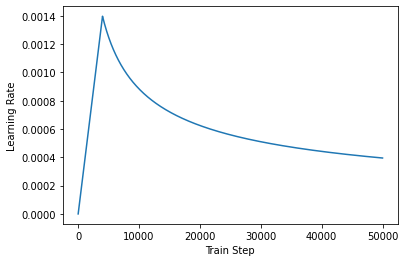

In [66]:
learning_rate = CustomSchedule(d_model = DIM_MODEL)

plt.plot(learning_rate(tf.range(50000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [67]:
#with strategy.scope():
transformer.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    optimizer =  tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9),
                    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
                    weighted_metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='w_accuracy'),
                                        Weighted_Loss(name='w_loss'), 
                                        Factor(name='factor'),                                         
                                       ])   # 'weighted' because we want to take padding masks into account 

In [68]:
weights = transformer.get_weights()

In [ ]:
#transformer.set_weights(weights)

In [93]:
#tf.random.set_seed(1)



my_callback = My_Callback(timeout=12*60*60, 
                          num_best_models=5, 
                          monitor='val_w_accuracy', 
                          mode='max',
                          log_file = os.path.join(package_path, 'logs.txt'),
                          report_freq = 50,
                          checkpoint_path = checkpoint_path,
                          save_weights_only = False,
                          reload_best_weights = True,
                          verbose = 1)




history = transformer.fit(train_dataset, 
                          validation_data = valid_dataset, 
                          epochs = 900,
                          steps_per_epoch = 700,
                          callbacks = [my_callback],
                          verbose = 0)



In [94]:
transformer.top_epochs

ListWrapper([(72, 0.6304840445518494), (66, 0.6314554214477539), (62, 0.6315970420837402), (59, 0.6317589282989502), (67, 0.6332159638404846)])

In [97]:
transformer.save(package_path)

In [ ]:
#transformer = tf.keras.models.load_model('./test/transformer', custom_objects = {'MHA': MHA, 
#                      'MHAU': MHAU, 
#                      'PositionalEmbedding': PositionalEmbedding, 
#                      'Weighted_Loss': Weighted_Loss,
#                      'Factor': Factor,
#                      'CustomSchedule': CustomSchedule,
#                      'My_Callback': My_Callback})

## Results

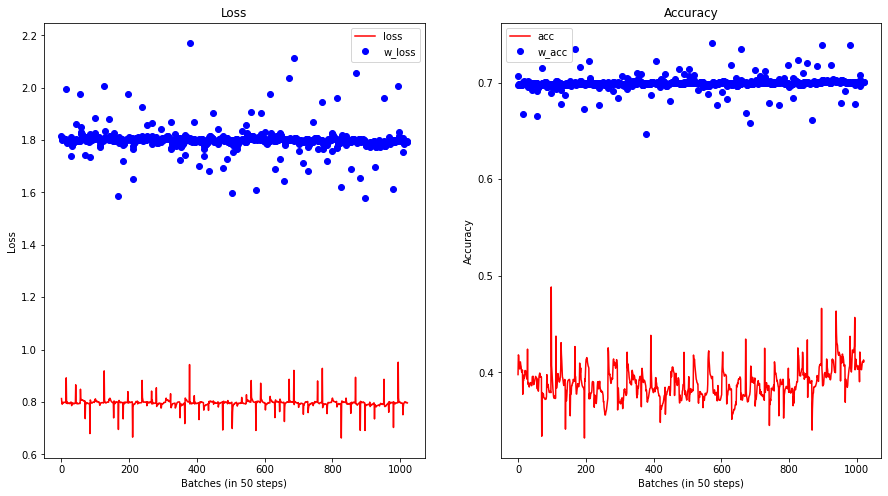

In [95]:
loss = transformer.History['loss']
w_loss = transformer.History['w_loss']
acc = transformer.History['accuracy']
w_acc = transformer.History['w_accuracy']
epochs = range(len(loss))

plt.figure(figsize=(15,8))
plt.subplot(121)
plt.plot(epochs, loss, color='r', label='loss')
plt.plot(epochs, w_loss, 'bo', label='w_loss')
plt.xlabel('Batches (in 50 steps)')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc, color='r', label='acc')
plt.plot(epochs, w_acc, 'bo', label='w_acc')
plt.xlabel('Batches (in 50 steps)')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

#plt.show()
plt.savefig(os.path.join(package_path, 'History.png'))

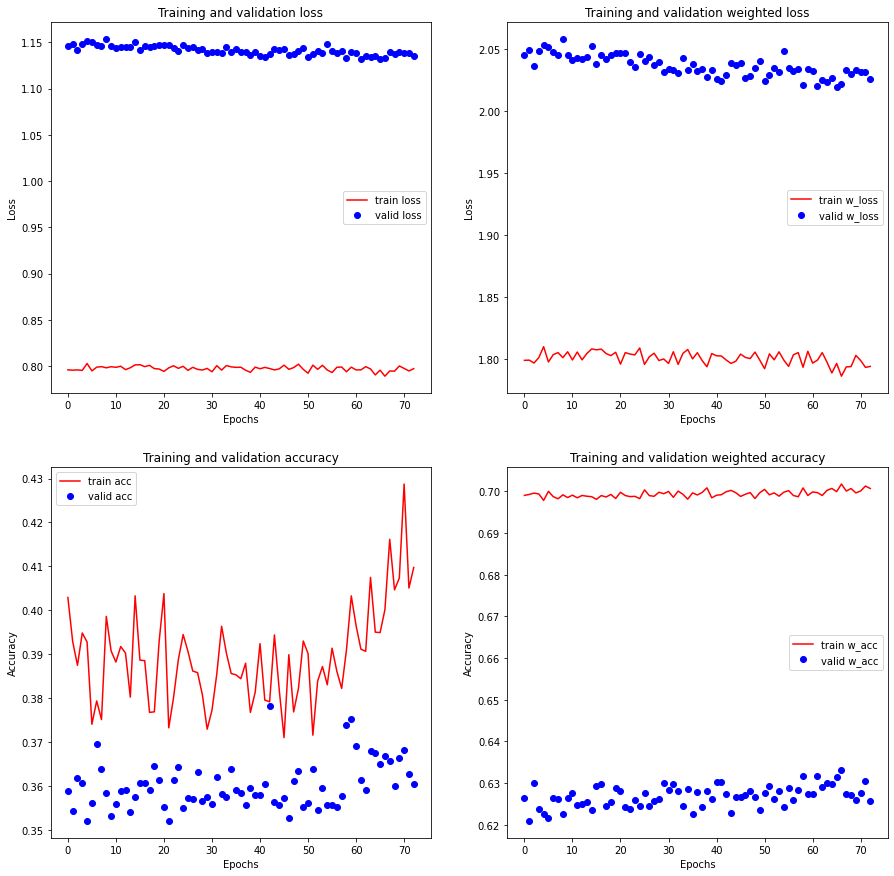

In [96]:
loss = transformer.history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
w_loss = history.history['w_loss']
val_w_loss = history.history['val_w_loss']
w_acc = history.history['w_accuracy']
val_w_acc = history.history['val_w_accuracy']
epochs = range(len(loss))

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.plot(epochs, loss, color='r', label='train loss')
plt.plot(epochs, val_loss, 'bo', label='valid loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()

plt.subplot(223)
plt.plot(epochs, acc, color='r', label='train acc')
plt.plot(epochs, val_acc, 'bo', label='valid acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(222)
plt.plot(epochs, w_loss, color='r', label='train w_loss')
plt.plot(epochs, val_w_loss, 'bo', label='valid w_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation weighted loss')
plt.legend()

plt.subplot(224)
plt.plot(epochs, w_acc, color='r', label='train w_acc')
plt.plot(epochs, val_w_acc, 'bo', label='valid w_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and validation weighted accuracy')
plt.legend()

#plt.show()
plt.savefig(os.path.join(package_path, 'history.history.png'))

## Combining the best models

In [ ]:
def build_combined_model(model):
    inputs = {name: inp for (name, inp) in zip(model.input_names, model.inputs)}

    ckpts = [os.path.join(model.checkpoint_path, f"{epoch:03d}-{metric:.3f}") for (epoch, metric) in model.top_epochs]
    custom_objects = {'MHA': MHA, 
                      'MHAU': MHAU, 
                      'PositionalEmbedding': PositionalEmbedding, 
                      'Weighted_Loss': Weighted_Loss,
                      'Factor': Factor,
                      'CustomSchedule': CustomSchedule,
                      'My_Callback': My_Callback}
    models = [ tf.keras.models.load_model(ckpt, custom_objects=custom_objects) for ckpt in ckpts]
    
    # renaming the models to avoid conflicts while initializing the combined model later
    for i, _model in enumerate(models):
        _model._name = model.name + f'_{i}'
    
    # computing the mean of all outputs by adding them up and dividing through the number of models
    outp_sum = tf.keras.layers.Add()([_model(inputs) for _model in models])
    factor = tf.constant(1./len(ckpts), outp_sum.dtype)
    outp = Scale(factor)(outp_sum)
    
    # initializing and compiling the combined model
    combined_model = tf.keras.Model(inputs=inputs, outputs = outp)
    combined_model.compile( loss = model.loss,
                            optimizer =  model.optimizer,
                            metrics = model.compiled_metrics._metrics,
                            weighted_metrics = model.compiled_metrics._weighted_metrics)

    return combined_model


combined_transformer = build_combined_model(transformer)

In [ ]:
transformer.evaluate(valid_dataset)

In [ ]:
combined_transformer.evaluate(valid_dataset)

In [ ]:
# transformer.summary()

In [ ]:
# combined_transformer.summary()

In [ ]:

#combined_transformer.save()

## Inference using Beam Search

In [ ]:
BEAM_WIDTH = 3

In [ ]:
bs = BeamSearch(transformer, tokenizer, BEAM_WIDTH, MAX_LENGTH)

In [ ]:

bs.translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")

In [ ]:
bs.translate("este é um problema que temos que resolver.")

In [ ]:
bs.translations("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

In [ ]:
bs.translations("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")


In [ ]:
bs.translations("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

In [ ]:
bs.translations("este é o primeiro livro que eu fiz.")
print ("Real translation: this is the first book i've ever done.")

In [ ]:
bs.translations("este é o primeiro livro que eu fiz.")
print ("Real translation: this is the first book i've ever done.")

## Exporting the translator

### Saving the model and restricting the possible input signatures

In [ ]:
input_signature = [{'encoder_input': tf.TensorSpec(shape=[None, None], dtype=tf.int32),
                     'decoder_input': tf.TensorSpec(shape=[None, None], dtype=tf.int32)}]

@tf.function(experimental_relax_shapes=True, input_signature=input_signature)
def inference(inputs):
    return transformer(inputs)

signatures = {'serving_default': inference}

In [ ]:
transformer.save('./test/transformer/v1')

### Loading the model and wrapping it into a tf.function to avoid unnecessary tracing.

In [ ]:
MAX_LENGTH = 40
BEAM_WIDTH = 3

In [ ]:
loaded_model = tf.saved_model.load('./test/transformer/v1')
training = False  # change this, if the model should be trained again

input_signature = [{'encoder_input': tf.TensorSpec(shape=[None, None], dtype=tf.int32, name='encoder_input'),
                     'decoder_input': tf.TensorSpec(shape=[None, None], dtype=tf.int32, name='decoder_input')}]
    
@tf.function(experimental_relax_shapes=True, input_signature=input_signature)
def wrapped_model(inputs):
    print(f"Tracing with encoder input = {inputs['encoder_input']} and decoder input = {inputs['decoder_input']}")
    return loaded_model(inputs, training=training)

# We wrap again to allow a 'training = False' argument in BeamSearch.__call__() algorithm 
def translator(inputs, **kwargs):
    return wrapped_model(inputs)

In [15]:
inp_tokenizer_file = os.path.join(vocabulary_path, 'input_vocabulary')
outp_tokenizer_file = os.path.join(vocabulary_path, 'output_vocabulary')

# creating a dictionary of tokenizers
tokenizer = {}
tokenizer['input'] = tfds.features.text.SubwordTextEncoder.load_from_file(inp_tokenizer_file)
tokenizer['output'] = tfds.features.text.SubwordTextEncoder.load_from_file(outp_tokenizer_file)

In [ ]:
bs = BeamSearch(translator, tokenizer, BEAM_WIDTH, MAX_LENGTH)

In [ ]:
bs2.translations("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

### This version does not work after deleting all variables in memory, problem is with pyfunc

In [ ]:
@tf.function
def tf_translate(sentence):
    translation, probability = tf.py_function(func = lambda sentence: bs.translate(sentence.numpy()), 
                                              inp = [sentence], Tout = [tf.string, tf.float32])
    return {'translation': translation, 'probability': probability}

    

signatures = { 'serving_default': tf_translate.get_concrete_function(tf.TensorSpec(shape=[], dtype=tf.string)) }


In [ ]:
transformer.save('./test/transformer/v2', signatures=signatures)

In [ ]:
translator = tf.saved_model.load('./test/transformer/v2').signatures['serving_default']
translator(tf.constant("este é um problema que temos que resolver."))

In [ ]:
translator(tf.constant("os meus vizinhos ouviram sobre esta ideia."))

In [ ]:
translator(tf.constant("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."))

In [ ]:
translator(tf.constant("vou então muito rapidamente partilhar  histórias de algumas coisas mágicas que aconteceram."))

In [ ]:
translator(tf.constant("este é o primeiro livro que eu fiz."))

### Setting up the TensorFlow Server (not working at the moment)

In [ ]:
MODEL_DIR = './test/transformer'
VERSION = 1

export_path = os.path.join(MODEL_DIR, str(VERSION))

transformer.save(export_path)

In [ ]:
%%bash --bg
tensorflow_model_server \
    --rest_api_port =8501  \
    --model_name=translator  \
    --model_base_path="${MODEL_DIR}" > server.log 2>&1

In [ ]:
%%bash

tail server.log

In [ ]:
%%bash --bg 
nohub tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=digits_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
model = tf.saved_model.load('./Transformer/checkpoints/001-0.624/')